## 1 Preliminaries

## 1.1 Imports and Configurations

### Imports

In [47]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from pandas.api.types import CategoricalDtype
from typing import List, Dict, Optional, Union
from sklearn.feature_selection import mutual_info_regression
from ydata_profiling import ProfileReport

### Constants

In [48]:
# 1 Preliminaries

RANDOM_STATE = 42

RAW_TRAIN_PATH = Path("../data/raw/train.csv")
RAW_TEST_PATH = Path("../data/raw/test.csv")

FEATURES_CAT = ["Sex"]

# 2 Feature Utility Scores

MI_SCORES_FEATURE_TO_ESTIMATE = "Calories"

# 3 Feature Engineering

DROP_FEATURES_AFTER_ENGINEERING = (
    "Is_High_BMI",
    "Sex",
    "Age_Grop",
)

REPORTS_DIR = Path("../reports/")
REPORTS_DIR.mkdir(exist_ok=True)

FINAL_TRAIN_PATH = Path("../data/final/train.csv")
FINAL_TEST_PATH = Path("../data/final/test.csv")

### Configs

In [49]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## 1.2 Data Preprocessing

### Read

In [50]:
def read_data(path: Union[str, Path]) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0)
    return df

In [51]:
df_train = read_data(RAW_TRAIN_PATH)

In [52]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB


In [53]:
df_test = read_data(RAW_TEST_PATH)

In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 750000 to 999999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         250000 non-null  object 
 1   Age         250000 non-null  int64  
 2   Height      250000 non-null  float64
 3   Weight      250000 non-null  float64
 4   Duration    250000 non-null  float64
 5   Heart_Rate  250000 non-null  float64
 6   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 15.3+ MB


### Missing Values

In [55]:
df_train.isna().sum().sum()

np.int64(0)

In [56]:
df_test.isna().sum().sum()

np.int64(0)

### Encode

In [57]:
def encode(
    df: pd.DataFrame,
    features_cat: Optional[List[str]] = None,
    features_date: Optional[List[str]] = None,
    feature_ord_levels: Optional[Dict[str, List[str]]] = None,
    format: str = "%d-%m-%Y",
) -> pd.DataFrame:

    def encode_cat(df: pd.DataFrame, features_cat: List[str]) -> pd.DataFrame:
        for feature in features_cat:
            if feature in df.columns:
                df[feature] = df[feature].astype("category")
        return df

    def encode_date(df: pd.DataFrame, features_date: List[str]) -> pd.DataFrame:
        for feature in features_date:
            if feature in df.columns:
                df[feature] = pd.to_datetime(
                    df[feature], format=format, errors="coerce"
                )
        return df

    def encode_ord(
        df: pd.DataFrame, feature_ord_levels: Dict[str, List[str]]
    ) -> pd.DataFrame:
        for feature, levels in feature_ord_levels.items():
            if feature in df.columns:
                cat_type = CategoricalDtype(categories=levels, ordered=True)
                df[feature] = df[feature].astype(str).astype(cat_type)
        return df

    if features_cat:
        df = encode_cat(df, features_cat)

    if features_date:
        df = encode_date(df, features_date)

    if feature_ord_levels:
        df = encode_ord(df, feature_ord_levels)

    return df

In [58]:
df_train_encoded = encode(df_train_cleaned, features_cat=FEATURES_CAT)

### Summary

In [59]:
def preprocess_data(
    path: str,
    features_cat: Optional[List[str]] = None,
    features_date: Optional[List[str]] = None,
    feature_ord_levels: Optional[Dict[str, List[str]]] = None,
) -> pd.DataFrame:

    df = read_data(path)
    df = encode(
        df,
        features_cat=features_cat or [],
        features_date=features_date or [],
        feature_ord_levels=feature_ord_levels or {},
        format="%d/%m/%Y",
    )

    return df

In [60]:
df_train_preprocessed = preprocess_data(path=RAW_TRAIN_PATH, features_cat=FEATURES_CAT)

In [61]:
df_train_preprocessed.dtypes

Sex           category
Age              int64
Height         float64
Weight         float64
Duration       float64
Heart_Rate     float64
Body_Temp      float64
Calories       float64
dtype: object

## 2 Feature Utility Scores

## 2.1 MI Scores

In [20]:
def make_mi_scores(
    X: pd.DataFrame, y: Union[pd.Series, np.ndarray], random_state: int = 0
) -> pd.Series:
    X = X.copy()
    for feature in X.select_dtypes(["object", "category", "datetime64[ns]"]):
        X[feature], _ = X[feature].factorize()
        X[feature] = X[feature].astype(int).fillna(-1)

    discrete_features: list[bool] = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=random_state
    )
    mi_scores_series = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    return mi_scores_series.sort_values(ascending=False)

In [21]:
def plot_mi_scores(scores: pd.Series) -> None:
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)

    plt.figure(figsize=(10, 6))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

In [21]:
X_mi = df_train_preprocessed.copy()
y_mi = X_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

mi_scores = make_mi_scores(X_mi, y_mi, random_state=RANDOM_STATE)
mi_scores

Duration      1.638435
Body_Temp     1.119307
Heart_Rate    0.976208
Age           0.095728
Weight        0.054552
Height        0.053719
Sex           0.016690
Name: MI Scores, dtype: float64

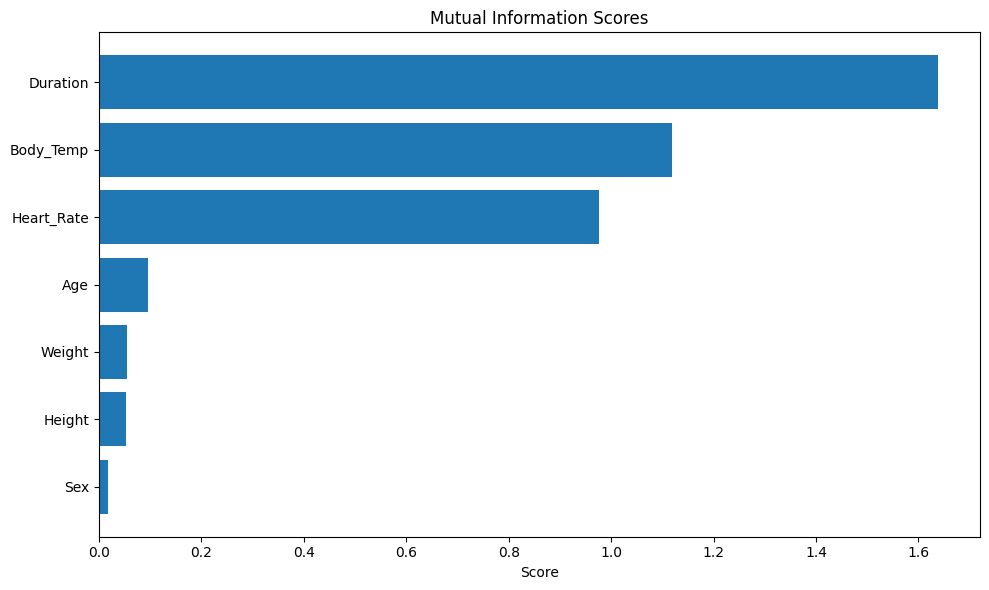

In [22]:
plot_mi_scores(mi_scores)

## 3 Feature Engineering

## 3.1 Binning

In [62]:
def feature_binning(
    df: pd.DataFrame,
    add_age_group: bool = True,
    add_hr_group: bool = True,
    add_duration_group: bool = True,
) -> pd.DataFrame:

    df = df.copy()

    if add_age_group and "Age" in df.columns:
        df["Age_Group"] = pd.cut(
            df["Age"],
            bins=[0, 25, 40, 60, 100],
            labels=["until25", "25-40", "40-60", "60-100"],
        )

    if add_hr_group and "Heart_Rate" in df.columns:
        df["Heart_Rate_Group"] = pd.cut(
            df["Heart_Rate"],
            bins=[0, 90, 100, 200],
            labels=[
                "low",
                "normal",
                "high",
            ],
        )

    if add_duration_group and "Duration" in df.columns:
        df["Duration_Group"] = pd.qcut(
            df["Duration"], q=4, labels=["short", "medium", "long", "very_long"]
        )

    return df

In [63]:
df_train_feature_binning = feature_binning(df_train_preprocessed)

## 3.2 Feature Transformation

In [64]:
def feature_transformation(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()

    if "Body_Temp" in df.columns:
        df["Body_Temp_Deviation"] = df["Body_Temp"] - 36.5
        df["Is_Fever"] = (df["Body_Temp"] >= 40.0).astype(int)

    if "Heart_Rate" in df.columns:
        df["Heart_Rate_Deviation"] = df["Heart_Rate"] - 60

    if "Duration" in df.columns:
        df["Log_Duration"] = np.log1p(df["Duration"])
        df["Is_Short_Session"] = (df["Duration"] < 10).astype(int)

    if "Weight" in df.columns:
        df["Log_Weight"] = np.log1p(df["Weight"])

    if "Age" in df.columns:
        df["Log_Age"] = np.log1p(df["Age"])

    return df

In [65]:
df_train_feature_transformation = feature_transformation(df_train_feature_binning)

## 3.3 Interactions

In [66]:
def feature_interactions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if "Weight" in df.columns and "Height" in df.columns:
        df["BMI"] = df["Weight"] / ((df["Height"] / 100) ** 2)
        df["Is_High_BMI"] = (df["BMI"] > 27).astype(int)

    if (
        "Duration" in df.columns
        and "Heart_Rate" in df.columns
        and "Weight" in df.columns
    ):
        df["Calories_Est"] = df["Duration"] * df["Heart_Rate"] * df["Weight"] / 10000
        df["Log_Calories_Est"] = np.log1p(df["Calories_Est"])

    if "Duration" in df.columns and "Heart_Rate" in df.columns:
        df["Effort"] = df["Duration"] * df["Heart_Rate"]
        df["Log_Effort"] = np.log1p(df["Effort"])

    if "Heart_Rate" in df.columns and "Age" in df.columns:
        df["Intensity_Index"] = df["Heart_Rate"] / (220 - df["Age"])

    if "Duration" in df.columns and "Weight" in df.columns:
        df["Effort_Per_Kg"] = df["Duration"] * df["Heart_Rate"] / df["Weight"]
        df["Log_Effort_Per_Kg"] = np.log1p(df["Effort_Per_Kg"])

    if "Duration" in df.columns and "Age" in df.columns:
        df["Duration_Per_Age"] = df["Duration"] / df["Age"]

    return df

In [67]:
df_train_feature_interactions = feature_interactions(df_train_feature_transformation)

## 3.4 MI Scores for New Features

In [68]:
X_new_mi = df_train_feature_interactions.copy()
y_new_mi = X_new_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

new_mi_scores = make_mi_scores(X_new_mi, y_new_mi, random_state=RANDOM_STATE)
new_mi_scores

NameError: name 'make_mi_scores' is not defined

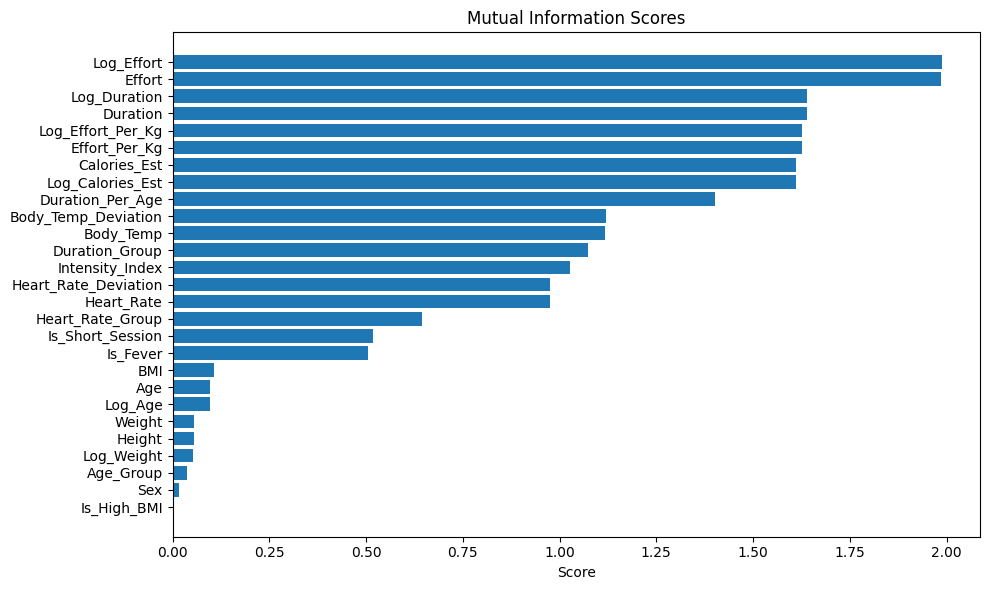

In [30]:
plot_mi_scores(new_mi_scores)

## 3.5 Create Features

In [69]:
def create_features(
    df: pd.DataFrame, drop_features_after_engineering: Union[list, tuple]
) -> pd.DataFrame:

    df = df.copy()

    df = feature_binning(df)
    df = feature_transformation(df)
    df = feature_interactions(df)
    
    features_to_drop = [
        col for col in drop_features_after_engineering if col in df.columns
    ]
    df.drop(columns=features_to_drop, inplace=True)

    return df

In [70]:
df_train_feature_engineering = create_features(
    df_train_preprocessed,
    drop_features_after_engineering=DROP_FEATURES_AFTER_ENGINEERING,
)

In [71]:
df_train_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Age                   750000 non-null  int64   
 1   Height                750000 non-null  float64 
 2   Weight                750000 non-null  float64 
 3   Duration              750000 non-null  float64 
 4   Heart_Rate            750000 non-null  float64 
 5   Body_Temp             750000 non-null  float64 
 6   Calories              750000 non-null  float64 
 7   Age_Group             750000 non-null  category
 8   Heart_Rate_Group      750000 non-null  category
 9   Duration_Group        750000 non-null  category
 10  Body_Temp_Deviation   750000 non-null  float64 
 11  Is_Fever              750000 non-null  int64   
 12  Heart_Rate_Deviation  750000 non-null  float64 
 13  Log_Duration          750000 non-null  float64 
 14  Is_Short_Session      750000 non-null  in

## 3.6 Feature Engineering Report

Summarize dataset:  64%|██████▍   | 305/474 [00:54<00:30,  5.62it/s, scatter Duration, Calories_Est]                    


KeyboardInterrupt: 

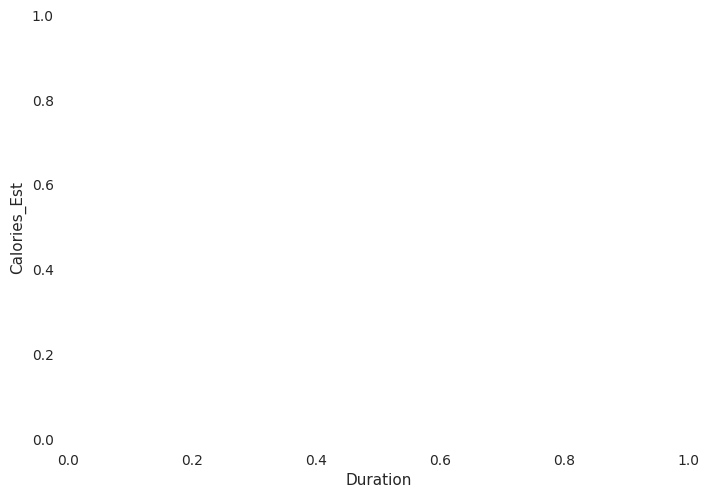

In [34]:
profile_report = ProfileReport(df_train_feature_engineering, title="Profile Report")
profile_report.to_file(REPORTS_DIR.joinpath("feature_engineering_report.html"))

## 4 Summary

## 4.1 Process Data

In [74]:
def process_data(
    path: Union[str, Path],
    features_cat: List[str] | None = None,
    features_date: List[str] | None = None,
    feature_ord_levels: Dict[str, List[str]] | None = None,
    drop_features_after_engineering: List[str] | None = None,
    is_test: bool = False,
) -> pd.DataFrame:

    df = preprocess_data(
        path,
        features_cat=features_cat,
        features_date=features_date,
        feature_ord_levels=feature_ord_levels,
    )
    df = create_features(
        df=df, drop_features_after_engineering=drop_features_after_engineering
    )
    
    if not is_test:
        df = df.drop_duplicates()
    
    return df

In [75]:
df_train_processed = process_data(
    RAW_TRAIN_PATH,
    features_cat=FEATURES_CAT,
    drop_features_after_engineering=DROP_FEATURES_AFTER_ENGINEERING,
)

In [76]:
df_test_processed = process_data(
    RAW_TEST_PATH,
    features_cat=FEATURES_CAT,
    drop_features_after_engineering=DROP_FEATURES_AFTER_ENGINEERING,
    is_test=True,
)

## 4.2 Save Final Data

In [79]:
df_train_processed.to_csv(FINAL_TRAIN_PATH)
df_test_processed.to_csv(FINAL_TEST_PATH)